#### Import Libraries

In [2]:
import cv2                          # image processing
import pickle                       # model serialization - saving it in a recoverable format
import numpy as np                  # linear algebra
import pandas as pd                 # deal with data
import seaborn as sns               # data visualization
import tensorflow as tf             # deep learning framework
from scipy import spatial           # math operations
import matplotlib.pyplot as plt     # plot data
from keras.datasets import fashion_mnist                 # dataset
from xgboost import XGBClassifier                        # xgboost classifier
from sklearn.ensemble import RandomForestClassifier      # random forest classifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report                               # classifier performance measurement
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau    # deep learning operations

In [3]:
tf.config.list_physical_devices('GPU') # use gpu as computation unit

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Get Data and Info about Data

##### Prepare Data

In [4]:
# connect to google drive and specify project directory ---- used data stored in csv format to get insights about data
from google.colab import drive
drive.mount('/content/drive')

basepath = '/content/drive/Shareddrives/ECEN_758_Project'
traindata = pd.read_csv(basepath + '/blob/fashion-mnist_train.csv')
testdata = pd.read_csv(basepath + '/blob/fashion-mnist_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
'''
HELPER FUNCTIONS FOR DATA PROCESSING
'''
# Insights
def peekaboo(train_data, test_data):

  return ('-----TRAINDATA----', train_data['label'].value_counts()), ('----TESTDATA----',test_data['label'].value_counts()), traindata.head(), testdata.head(), traindata.describe(), testdata.describe()

# Conversion from 1D vector to 3D image matrix
def conversion_3D(data):

  images = data.drop('label', axis=1)
  print(images.shape)
  images_2d = np.array(images).reshape(len(images), 28, 28, 1)
  print(images_2d.shape)
  return images_2d

# Conversion from 1D vector to 2D image matrix
def conversion_2D(data):

  images = data.drop('label', axis=1)
  print(f'Shape of images before conversion: {images.shape}')
  images_2d = np.array(images).reshape(len(images), 28, 28)
  print(f'Shape of images after conversion: {images_2d.shape}')
  return images_2d

# Labels
def getlabels(data):

  labelsarray = np.unique(data['label'])
  typesarray = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  labels_info = {}
  for i in labelsarray:
    labels_info.update({i: typesarray[i]})

  labels = data['label']

  return labels, labels_info

# Normalize data
def normalize(data: np.array):

  return data.astype('float32') / 255

# Display images
def display(images_array: np.array, labels: np.array, labels_info: dict, n: int):

  indices = np.random.randint(len(images_array), size=n)
  plt.figure(figsize=(10, 10))

  iter = 0
  for i in indices:

    label = labels_info[labels[i]]

    plt.subplot(6, 5, iter+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_array[i], cmap=plt.cm.binary)
    plt.xlabel(label)
    iter += 1

# calculate hash of images
def average_hash(image, hash_size=8):
    # Resize the image to the specified hash size
    image = cv2.resize(image, (hash_size, hash_size))

    # Calculate the average pixel value
    average = np.mean(image)

    # Create a binary hash
    hash_value = 0
    for row in range(hash_size):
        for col in range(hash_size):
            if image[row, col] > average:
                hash_value |= 1 << (row * hash_size + col)

    return hash_value

def hashes(imagearray_2D: np.array):

  hashlist = []
  for i in range(len(imagearray_2D)):

    hash = average_hash(imagearray_2D[i])
    hashlist.append(hash)

  return hashlist

# cosine similarity b/w images of different classes
def cosine_similarity(hashes_array1, hashes_array2):

  result = 1 - spatial.distance.cosine(hashes_array1, hashes_array2)

  return result

# similarity dataframe
def hashdataframe(hashdict: dict, labels_info_row: dict, labels_info_col: dict):

  similarities = {}
  for i in range (len(list(hashdict.values()))):

    items = []
    for j in range (len(list(hashdict.values()))):
      items.append(cosine_similarity(list(hashdict.values())[i], list(hashdict.values())[j]))

    similarities.update({i: items})

  similarities_df = pd.DataFrame.from_dict(similarities)
  similarities_df.columns = list(labels_info_col.values())
  similarities_df.index = list(labels_info_row.values())
  return similarities_df

In [6]:
train_labels, labels_info = getlabels(traindata)
test_labels, _ = getlabels(testdata)
print(f'What each label signifies\n{labels_info}')

What each label signifies
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [7]:
# getting data runtime via keras api

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
# data for convolutional neural network

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
from sklearn.model_selection import train_test_split
# train - validation split
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
# one hot encoding representation of the labels

y_train_clf_encoded = tf.one_hot(y_train_clf, depth = 10)
y_val_clf_encoded = tf.one_hot(y_val_clf, depth = 10)
y_test_clf_encoded = tf.one_hot(y_test, depth = 10)

In [11]:
# preparing data for random forest and xgboost

X_train_rf = X_train_clf.reshape(len(X_train_clf), 784)
X_val_rf = X_val_clf.reshape(len(X_val_clf), 784)
X_test_rf = x_test.reshape(len(x_test), 784)

##### Insights

In [14]:
train_images = conversion_2D(traindata)
train_images = normalize(train_images)

test_images = conversion_2D(testdata)
test_images = normalize(test_images)

train_labels, labels_info = getlabels(traindata)
test_labels, _ = getlabels(testdata)

Shape of images before conversion: (60000, 784)
Shape of images after conversion: (60000, 28, 28)
Shape of images before conversion: (10000, 784)
Shape of images after conversion: (10000, 28, 28)


TRAIN IMAGES


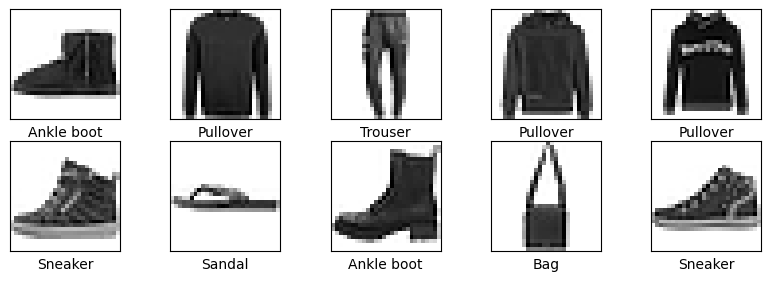

In [15]:
# visulizing training set
print('TRAIN IMAGES')
display(train_images, train_labels, labels_info, 10)

TEST IMAGES


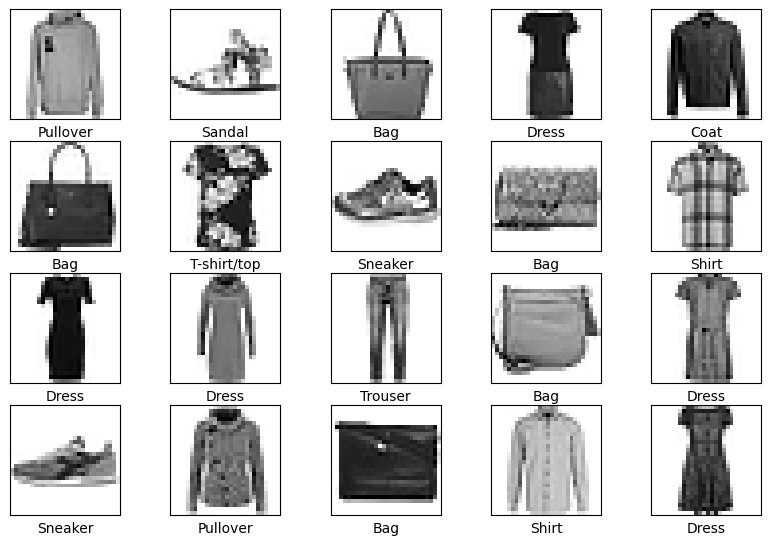

In [16]:
# visulizing test set
print('TEST IMAGES')
display(test_images, test_labels, labels_info, 20)

In [17]:
''' Dividing training set w.r.t their corresponding labels'''

train_images0 = train_images[train_labels == 0]
train_images1 = train_images[train_labels == 1]
train_images2 = train_images[train_labels == 2]
train_images3 = train_images[train_labels == 3]
train_images4 = train_images[train_labels == 4]
train_images5 = train_images[train_labels == 5]
train_images6 = train_images[train_labels == 6]
train_images7 = train_images[train_labels == 7]
train_images8 = train_images[train_labels == 8]
train_images9 = train_images[train_labels == 9]
print(f'{train_images0.shape}: Train Images 0, {train_images1.shape}: Train Images 1')
print(f'{train_images2.shape}: Train Images 2, {train_images3.shape}: Train Images 3')
print(f'{train_images4.shape}: Train Images 4, {train_images5.shape}: Train Images 5')
print(f'{train_images6.shape}: Train Images 6, {train_images7.shape}: Train Images 7')
print(f'{train_images8.shape}: Train Images 8, {train_images9.shape}: Train Images 9')

train_labels0 = train_labels[train_labels == 0]
train_labels1 = train_labels[train_labels == 1]
train_labels2 = train_labels[train_labels == 2]
train_labels3 = train_labels[train_labels == 3]
train_labels4 = train_labels[train_labels == 4]
train_labels5 = train_labels[train_labels == 5]
train_labels6 = train_labels[train_labels == 6]
train_labels7 = train_labels[train_labels == 7]
train_labels8 = train_labels[train_labels == 8]
train_labels9 = train_labels[train_labels == 9]
print(f'{train_labels0.shape}: y Train Label 0, {train_labels1.shape}: y Train Label 1')
print(f'{train_labels2.shape}: y Train Label 2, {train_labels3.shape}: y Train Label 3')
print(f'{train_labels4.shape}: y Train Label 4, {train_labels5.shape}: y Train Label 5')
print(f'{train_labels6.shape}: y Train Label 6, {train_labels7.shape}: y Train Label 7')
print(f'{train_labels8.shape}: y Train Label 8, {train_labels9.shape}: y Train Label 9')

(6000, 28, 28): Train Images 0, (6000, 28, 28): Train Images 1
(6000, 28, 28): Train Images 2, (6000, 28, 28): Train Images 3
(6000, 28, 28): Train Images 4, (6000, 28, 28): Train Images 5
(6000, 28, 28): Train Images 6, (6000, 28, 28): Train Images 7
(6000, 28, 28): Train Images 8, (6000, 28, 28): Train Images 9
(6000,): y Train Label 0, (6000,): y Train Label 1
(6000,): y Train Label 2, (6000,): y Train Label 3
(6000,): y Train Label 4, (6000,): y Train Label 5
(6000,): y Train Label 6, (6000,): y Train Label 7
(6000,): y Train Label 8, (6000,): y Train Label 9


In [18]:
# store calculate hash values for each class

hashesdict_train = {
    'hashes_train0' : np.array(hashes(train_images0)),
    'hashes_train1' : np.array(hashes(train_images1)),
    'hashes_train2' : np.array(hashes(train_images2)),
    'hashes_train3' : np.array(hashes(train_images3)),
    'hashes_train4' : np.array(hashes(train_images4)),
    'hashes_train5' : np.array(hashes(train_images5)),
    'hashes_train6' : np.array(hashes(train_images6)),
    'hashes_train7' : np.array(hashes(train_images7)),
    'hashes_train8' : np.array(hashes(train_images8)),
    'hashes_train9' : np.array(hashes(train_images9)),
}

In [19]:
similarities_df = hashdataframe(hashesdict_train, labels_info, labels_info)

<Axes: >

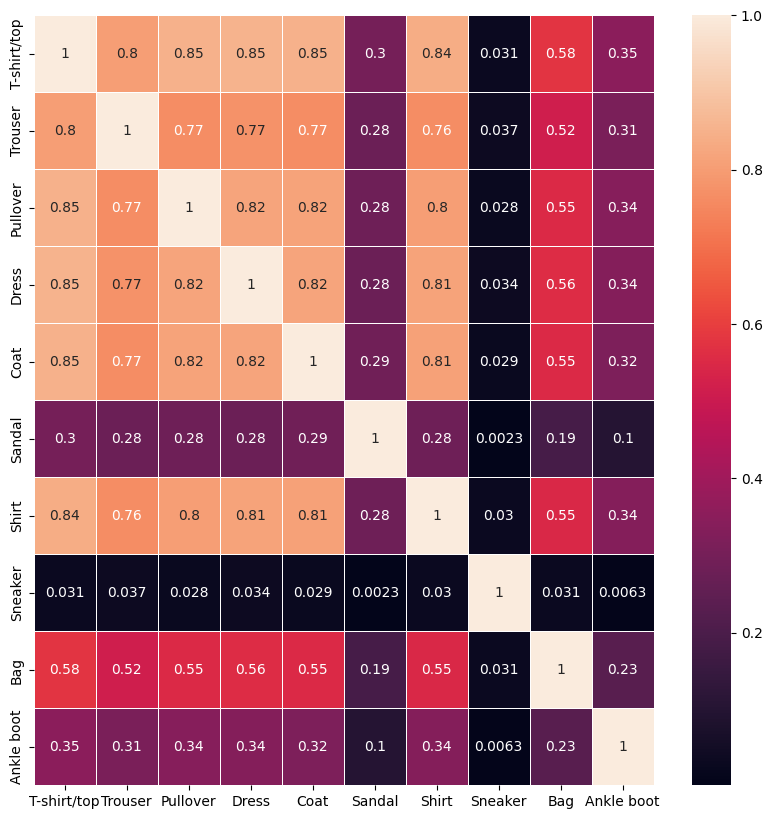

In [20]:
# depicts how data from different classes are related to each other

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(similarities_df, annot=True, linewidth=.5, ax=ax)

<function matplotlib.pyplot.show(close=None, block=None)>

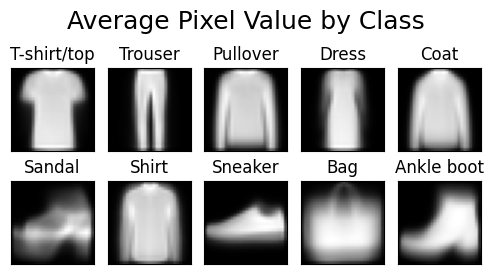

In [24]:
# exploratory data analysis
# get average of all pixels for each clothing type


# find number of samples from each class
# find indicies of each unique class
[out_labels, inverse_indices, counts] = np.unique(y_train_clf, return_counts=True, return_inverse=True)

# define figure/subplots
plt.figure(figsize=(5, 3))


plt.suptitle("Average Pixel Value by Class", fontsize=18, y=0.95)

img_means = np.empty(10, dtype = 'object')

for n, i_label in enumerate(labels_info):
  # create mask of T/F to get indices that match class i_label
  mask = y_train_clf == n
  # index training data given mask
  t_class = X_train_clf[mask,]


  # set axes and plot info
  ax = plt.subplot(2,5, n+1)
  img_means[n] = np.mean(t_class, 0)
  ax.imshow(img_means[n], cmap = "gray")
  ax.set_title(labels_info[n])
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout(h_pad = 1, w_pad=1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

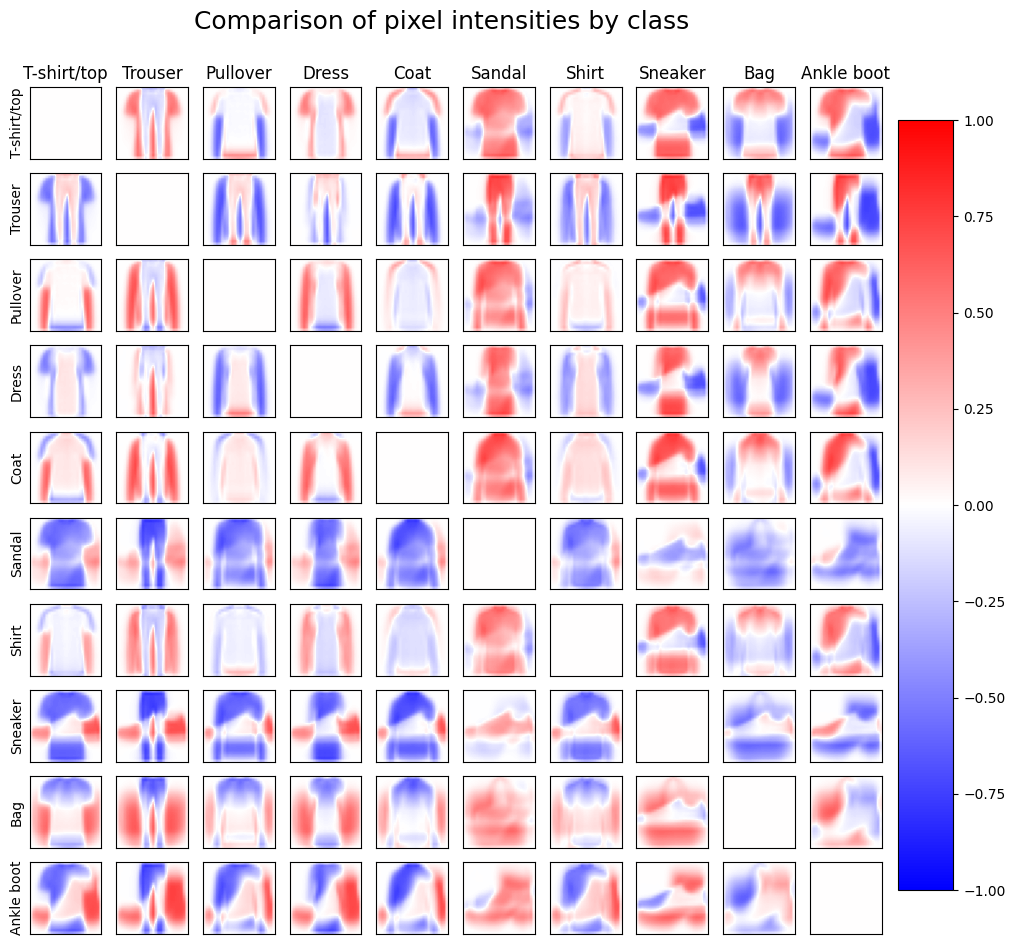

In [25]:
# exploratory data analysis
# pairwise comparison of classes

# define figure/subplots
fig = plt.figure(figsize=(11, 11))
#fig.subplots_adjust(hspace=0, wspace = 0)
fig.tight_layout()
fig.suptitle("Comparison of pixel intensities by class", fontsize=18, y=0.95)
p = 1;
for j, avg_outer in enumerate(img_means):
  for k, avg_inner in enumerate(img_means):
    # find difference between average of 2 classes
    diff1 = avg_outer - avg_inner

    # set axes and plot info
    ax = plt.subplot(10,10, p)
    im = ax.imshow(diff1, cmap="bwr", vmin = -1, vmax = 1 )
    ax.set_xticks([])
    ax.set_yticks([])

    if j == 0:
      ax.set_title(labels_info[k])
    if k == 0:
      ax.set_ylabel(labels_info[j])

    p += 1



fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.915, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show

#### Xception

In [ ]:
'''Tried Data Augmentation but rejected the idea of using it in the end'''
'''Reason: Not much improvement in performance; no point adding extra complexity'''

# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip("vertical"),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1),
#     ]
# )

In [ ]:
'''Architecture of the CNN'''

inputs = tf.keras.Input(shape=(28, 28, 1))
# x = data_augmentation(inputs)
x = inputs

x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    residual = x

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    residual = tf.keras.layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = tf.keras.layers.add([x, residual])

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
clf1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-10,
    amsgrad=False,
    weight_decay=None
)

In [ ]:
'''Controlled learning for the model'''

callbacks_list = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.001,
        patience=5,
        verbose=0,
        mode="auto",
        min_delta=0.00001,
        cooldown=0,
        min_lr=0,
    ),
    EarlyStopping(
        monitor="val_accuracy",
        patience=25,
    ),
    ModelCheckpoint(
        filepath="/content/drive/Shareddrives/ECEN_758_Project/xception_exps_I.h5",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [ ]:
'''Train the classifier'''

clf1.compile(loss="CategoricalCrossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "Precision", "Recall"])
history_clf1 = clf1.fit(
    X_train_clf,
    y_train_clf_encoded,
    epochs=250,
    batch_size=64,
    callbacks=callbacks_list,
    validation_data=(X_val_clf, y_val_clf_encoded)
)

Epoch 1/250
750/750 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.8079 - precision: 0.8517 - recall: 0.7706

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 78s 61ms/step - loss: 0.5499 - accuracy: 0.8079 - precision: 0.8517 - recall: 0.7706 - val_loss: 0.4164 - val_accuracy: 0.8522 - val_precision: 0.8801 - val_recall: 0.8292 - lr: 0.0010
Epoch 2/250
750/750 [==============================] - 42s 56ms/step - loss: 0.3911 - accuracy: 0.8638 - precision: 0.8876 - recall: 0.8439 - val_loss: 0.3898 - val_accuracy: 0.8637 - val_precision: 0.8817 - val_recall: 0.8506 - lr: 0.0010
Epoch 3/250
750/750 [==============================] - 45s 60ms/step - loss: 0.3396 - accuracy: 0.8833 - precision: 0.9024 - recall: 0.8667 - val_loss: 0.3429 - val_accuracy: 0.8833 - val_precision: 0.9045 - val_recall: 0.8622 - lr: 0.0010
Epoch 4/250
750/750 [==============================] - 36s 48ms/step - loss: 0.3098 - accuracy: 0.8939 - precision: 0.9101 - recall: 0.8789 - val_loss: 0.3582 - val_accuracy: 0.8816 - val_precision: 0.8965 - val_recall: 0.8694 - lr: 0.0010
Epoch 5/250
750/750 [==============================]

In [ ]:
clf1.summary() # Architecture of Xception in a human readable format

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 24, 24, 32)           800       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 24, 24, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 24, 24, 32)           0         ['batch_normalization[0][0

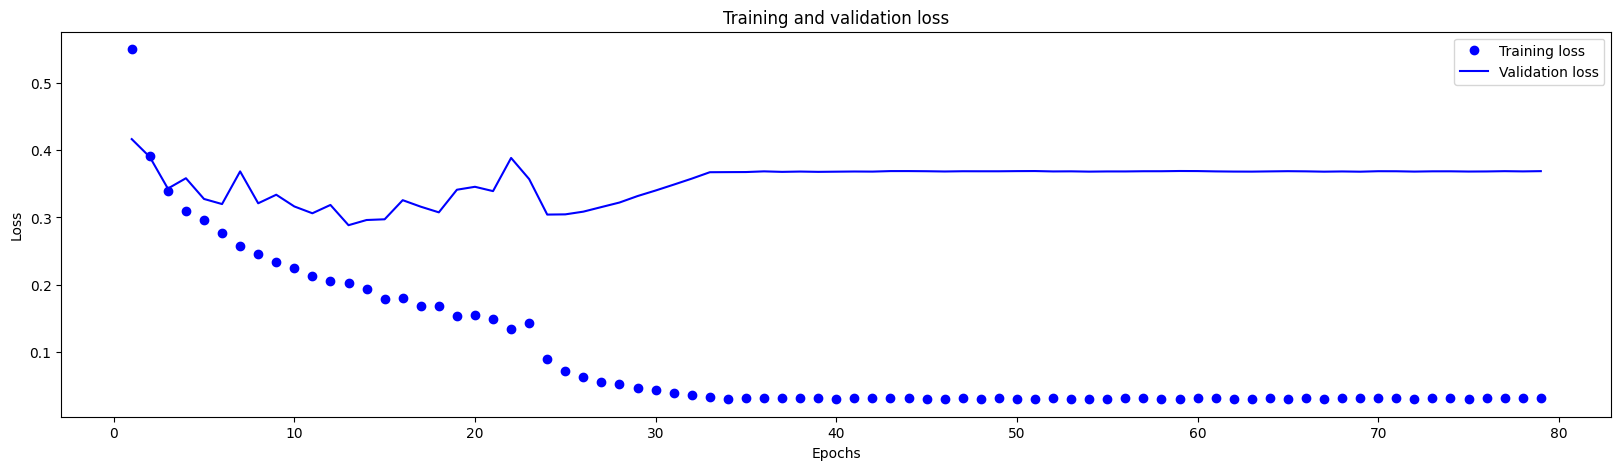

In [ ]:
# Training Performance

history_clf_dict = history_clf1.history
loss_values = history_clf_dict["loss"]
val_loss_values = history_clf_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(20,5))
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

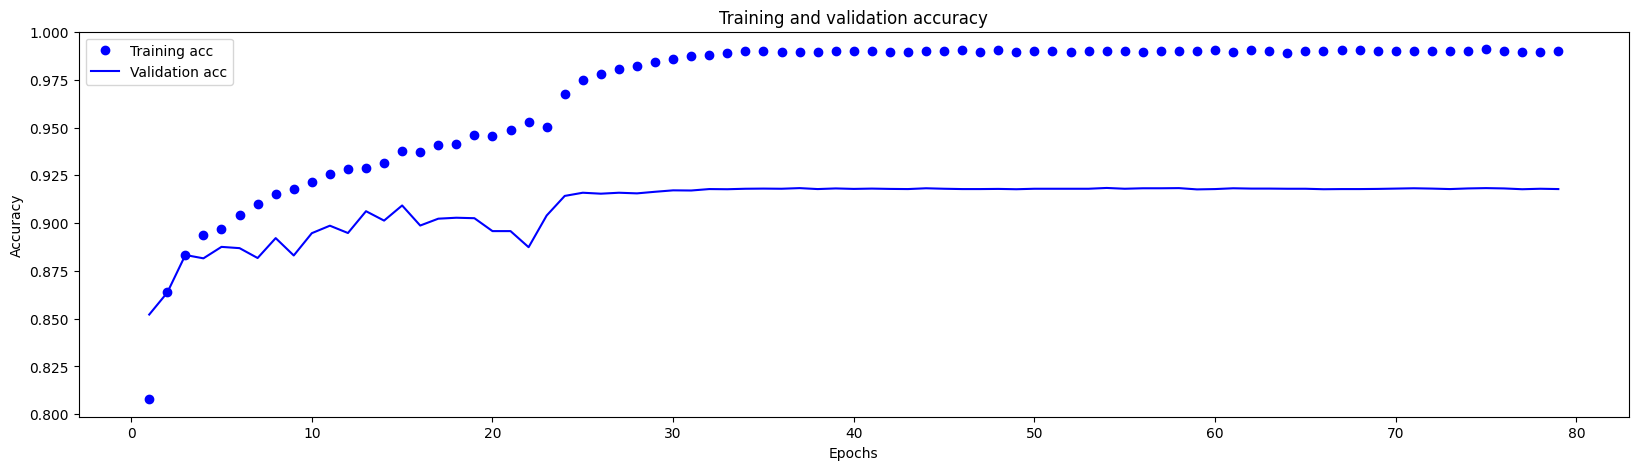

In [ ]:
# Training Performance

acc = history_clf_dict["accuracy"]
val_acc = history_clf_dict["val_accuracy"]
plt.figure(figsize=(20,5))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
'''Load and test the model'''

xception = tf.keras.saving.load_model('/content/drive/Shareddrives/ECEN_758_Project/xception_stable_IV.h5')

In [ ]:
test_loss, test_acc, test_precision, test_recall = xception.evaluate(x_test, y_test_clf_encoded)

accuracy_score = round(test_acc*1000) / 10
precision_score = round(test_precision*1000) / 10
recall_score = round(test_recall*1000) / 10

print(f"accuracy score: {accuracy_score}")
print(f"precison score: {precision_score}")
print(f"recall score: {recall_score}")

313/313 [==============================] - 12s 10ms/step - loss: 0.2899 - accuracy: 0.9117 - precision: 0.9185 - recall: 0.9055
accuracy score: 91.2
precison score: 91.8
recall score: 90.5


313/313 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.98      0.98      0.98      1000
           2       0.88      0.87      0.88      1000
           3       0.90      0.91      0.90      1000
           4       0.86      0.87      0.87      1000
           5       0.97      0.97      0.97      1000
           6       0.76      0.75      0.75      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



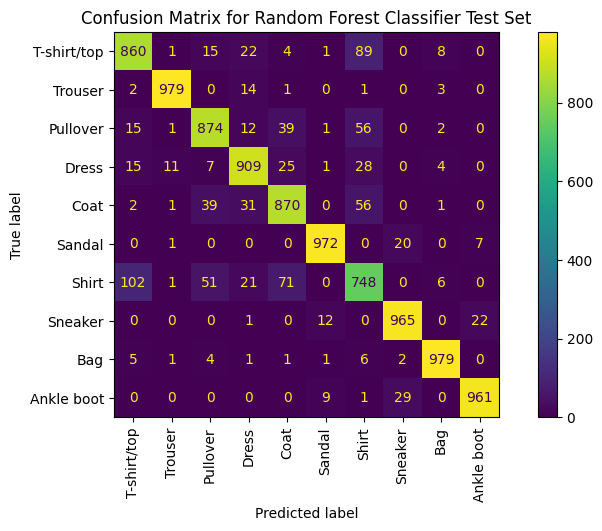

In [ ]:
xception_test_proba = xception.predict(x_test)
xception_test_labels = []
for i in range(len(xception_test_proba)):
  xception_test_label = np.argmax(xception_test_proba[i])
  xception_test_labels.append(xception_test_label)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, xception_test_labels, ax=ax)
ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels_info.values())
_ = ax.set_title(
    f"Confusion Matrix for Random Forest Classifier Test Set"
)

print(classification_report(y_test, xception_test_labels))

#### RANDOM FOREST

In [ ]:
'''Train and Test our baseline Random Forest classifier'''
randomForest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=35, random_state=20)

In [ ]:
randomForest.fit(X_train_rf, y_train_clf)

In [ ]:
import pickle

filename = 'randomForestClassifier.pkl'
pickle.dump(randomForest,  open(filename, 'wb'))

In [ ]:
# predict values for validation set
y_val_rf = randomForest.predict(X_val_rf)
print(classification_report(y_val_clf, y_val_rf))

In [ ]:
# predict values for test set
y_test_rf = randomForest.predict(X_test_rf)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_rf, ax=ax)
ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels_info.values())
_ = ax.set_title(
    f"Confusion Matrix for Random Forest Classifier Test Set"
)

print(classification_report(y_test, y_test_rf))

#### XGBoost

In [ ]:
'''Baseline II -----> Train and Test XGBoost classifier'''

xgboost = XGBClassifier(n_estimators=196, max_depth=28, learning_rate=1)

In [ ]:
xgboost.fit(X_train_rf, y_train_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=35, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
import pickle

filename = 'xgboostClassifier.pkl'
pickle.dump(xgboost,  open('/content/drive/Shareddrives/ECEN_758_Project/' + filename, 'wb'))

In [ ]:
y_val_rf = xgboost.predict(X_val_rf)
print(classification_report(y_val_clf, y_val_rf))

In [ ]:
y_test_rf = xgboost.predict(X_test_rf)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_rf, ax=ax)
ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels_info.values())
_ = ax.set_title(
    f"Confusion Matrix for Random Forest Classifier Test Set"
)

print(classification_report(y_test, y_test_rf))

#### TEST THE CLASSIFIERS ----> RUN THIS TO EVALUATE

**[Run 'Get Data and Info about Data' -> Section: 'Prepare Data' before running this cell]**

##### Xception CNN ------> FINAL SUBMISSION

In [26]:
xception = tf.keras.saving.load_model('./xception_stable_IV.h5')

OSError: ignored

In [ ]:
test_loss, test_acc, test_precision, test_recall = xception.evaluate(x_test, y_test_clf_encoded)

accuracy_score = round(test_acc*1000) / 10
precision_score = round(test_precision*1000) / 10
recall_score = round(test_recall*1000) / 10

print(f"accuracy score: {accuracy_score}")
print(f"precison score: {precision_score}")
print(f"recall score: {recall_score}")

313/313 [==============================] - 12s 10ms/step - loss: 0.2899 - accuracy: 0.9117 - precision: 0.9185 - recall: 0.9055
accuracy score: 91.2
precison score: 91.8
recall score: 90.5


313/313 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.98      0.98      0.98      1000
           2       0.88      0.87      0.88      1000
           3       0.90      0.91      0.90      1000
           4       0.86      0.87      0.87      1000
           5       0.97      0.97      0.97      1000
           6       0.76      0.75      0.75      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



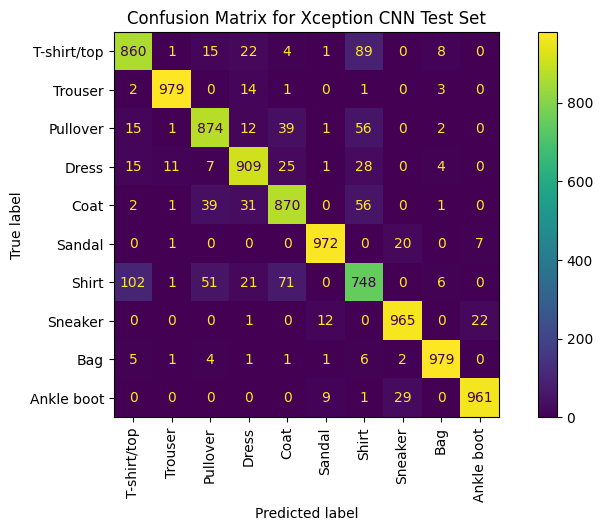

In [ ]:
xception_test_proba = xception.predict(x_test)
xception_test_labels = []
for i in range(len(xception_test_proba)):
  xception_test_label = np.argmax(xception_test_proba[i])
  xception_test_labels.append(xception_test_label)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, xception_test_labels, ax=ax)
ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels_info.values())
_ = ax.set_title(
    f"Confusion Matrix for Xception CNN Test Set"
)

print(classification_report(y_test, xception_test_labels))

##### Random Forest

In [ ]:
with open ('./randomForestClassifier.pkl', 'rb') as rf:

  randomforestClassifier = pickle.load(rf)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.80      0.78      1000
           3       0.86      0.91      0.89      1000
           4       0.76      0.82      0.79      1000
           5       0.97      0.96      0.97      1000
           6       0.71      0.58      0.64      1000
           7       0.92      0.94      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



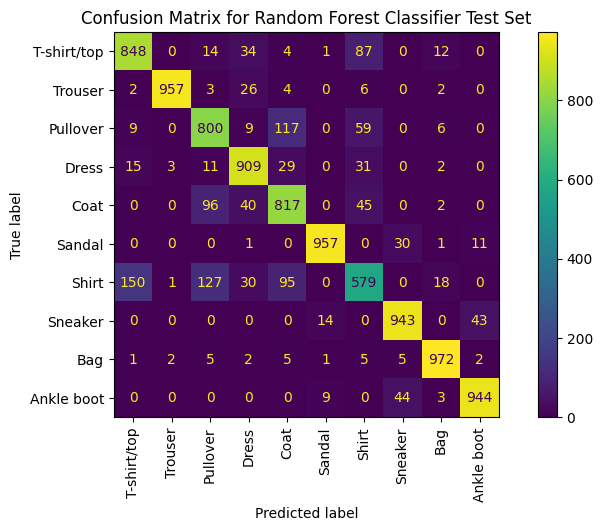

In [ ]:
y_test_rf = randomforestClassifier.predict(X_test_rf)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_rf, ax=ax)
ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels_info.values())
_ = ax.set_title(
    f"Confusion Matrix for Random Forest Classifier Test Set"
)

print(classification_report(y_test, y_test_rf))

##### XGBoost

In [ ]:
with open ('./xgboost.pkl', 'rb') as xgb:

  xgboostClassifier = pickle.load(xgb)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.79      0.84      0.81      1000
           3       0.89      0.92      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.63      0.68      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



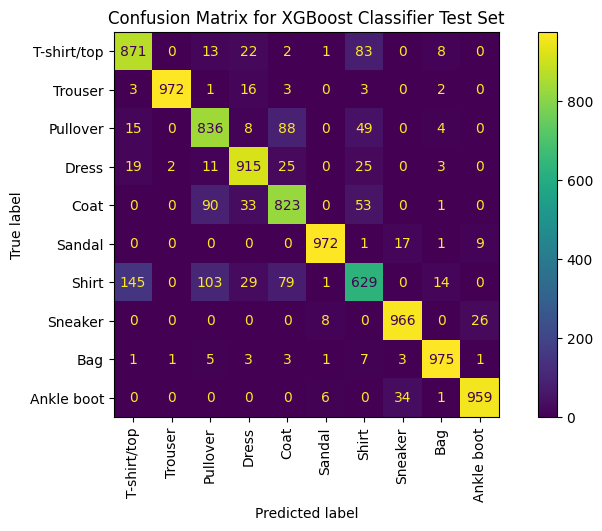

In [ ]:
y_test_rf = xgboostClassifier.predict(X_test_rf)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_rf, ax=ax)
ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels_info.values())
_ = ax.set_title(
    f"Confusion Matrix for XGBoost Classifier Test Set"
)

print(classification_report(y_test, y_test_rf))

#### Basic Pipeline Code - achieved the same metrics without pipeline | so, not required anymore

Idea was to check prediction conflicts between Xception and XGBoost then take the labels of the classifier that classifier the sample with greater probability

In [ ]:
xgboost = XGBClassifier(n_estimators=35, max_depth=15, learning_rate=1, device="cuda")

In [ ]:
xgboost.fit(X_train_rf, y_train_clf)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=35, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
filename = 'xgboost.pkl'
pickle.dump(xgboost,  open(filename, 'wb'))

In [ ]:
xgboostStable = pickle.load(open('/content/drive/Shareddrives/ECEN_758_Project/xgboost.pkl', 'rb'))

In [ ]:
y_val_rf = xgboostStable.predict(X_val_rf)
xgboost_val_proba = xgboostStable.predict_proba(X_test_rf)

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_val_rf, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

print(classification_report(y_val_clf, y_val_rf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1202
           1       0.99      0.98      0.99      1219
           2       0.82      0.85      0.84      1205
           3       0.88      0.93      0.90      1184
           4       0.82      0.85      0.84      1202
           5       0.98      0.97      0.97      1211
           6       0.77      0.65      0.70      1218
           7       0.95      0.96      0.96      1159
           8       0.97      0.97      0.97      1197
           9       0.96      0.97      0.96      1203

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [ ]:
y_test_rf = xgboostStable.predict(X_test_rf)
xgboost_test_proba = xgboostStable.predict_proba(X_test_rf)

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_predTest, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

print(classification_report(y_test, y_test_rf))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.79      0.84      0.81      1000
           3       0.89      0.92      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.63      0.68      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
def getconflicts(classifier1_labels, classifier2_labels):

  label_conflicts = np.where(np.not_equal(classifier1_labels, classifier2_labels))
  conflicts = []
  for i in label_conflicts[0]:
    conflicts.append(i)

  return conflicts, label_conflicts


def maxprobasFromCLF(classifer1probas, classifier2probas):

  maxprobas_classifier1 = []
  for i in range(len(classifer1probas)):
    maxprobas_classifier1.append(np.max(classifer1probas[i]))

  maxprobas_classifier2 = []
  for j in range(len(classifier2probas)):
    maxprobas_classifier2.append(np.max(classifier2probas[j]))

  return maxprobas_classifier1, maxprobas_classifier2


def getconflictlabels(conflictsArray, classifier1_labels, classifier2_labels):

  classifier1_coflict_labels = []
  for i in conflicts:
    classifier1_coflict_labels.append(classifier1_labels[i])

  classifier2_coflict_labels = []
  for i in conflicts:
    classifier2_coflict_labels.append(classifier2_labels[i])

  return classifier1_coflict_labels, classifier2_coflict_labels


def getconflictprobas(conflictsArray, classifier1_probas, classifier2_probas):

  classifier1_coflict_probas = []
  for i in conflicts:
    classifier1_coflict_probas.append(classifier1_probas[i])

  classifier2_coflict_probas = []
  for i in conflicts:
    classifier2_coflict_probas.append(classifier2_probas[i])

  return classifier1_coflict_probas, classifier2_coflict_probas


def finalLabelsGeneric(conflictsArray, classifier1_conflictProbas, classifier2_conflictProbas, classifier1_labels, classifier2_labels):

  xg = []
  xc = []
  xg_conflictprobas = []
  xc_conflictprobas = []

  for i in range(len(classifier1_conflictProbas)):
    if classifier1_conflictProbas[i] > classifier2_conflictProbas[i]:
      xg.append(conflictsArray[i])
      xg_conflictprobas.append(classifier1_conflictProbas[i])
    else:
      xc.append(conflictsArray[i])
      xc_conflictprobas.append(classifier2_conflictProbas[i])

  final_labels = classifier2_labels

  for i in xg:
    xg_label = classifier1_labels[i]
    final_labels[i] = xg_label

  return final_labels, xg_conflictprobas, xc_conflictprobas

In [ ]:
conflicts, _ = getconflicts(y_test_rf, xception_test_labels)
xgboost_probas, xception_probas = maxprobasFromCLF(xgboost_test_proba, xception_test_proba)
xgboost_coflict_labels, xception_coflict_labels = getconflictlabels(conflicts, y_test_rf, xception_test_labels)
xgboost_coflict_probas, xception_coflict_probas = getconflictprobas(conflicts, xgboost_probas, xception_probas)

In [ ]:
finalLabels_generic, xg_conflictprobas, xc_conflictprobas = finalLabelsGeneric(conflicts, xgboost_coflict_probas, xception_coflict_probas, y_test_rf, xception_test_labels)

In [ ]:
print(classification_report(y_test, finalLabels_generic))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.86      0.87      0.86      1000
           3       0.91      0.93      0.92      1000
           4       0.83      0.87      0.85      1000
           5       0.98      0.99      0.99      1000
           6       0.79      0.71      0.75      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
xg_conflictprobas

In [ ]:
confusingLabels = []
confusingSample = {}
for i in range(len(xception_test_labels)):

  if xception_test_labels[i] == 2 or xception_test_labels[i] == 6:
    confusingSample.update({i: x_test[i]})

In [ ]:
keys = list(confusingSample.keys())
print(np.unique(keys))
print(len(keys))

[   1    4    7 ... 9970 9971 9985]
1911


In [ ]:
keys[0:10]

[1, 4, 7, 16, 17, 20, 25, 26, 44, 46]

In [ ]:
exp_samples = list(confusingSample.values())

In [ ]:
exp_samples = np.array(exp_samples)

In [ ]:
exp_samples.shape

(1911, 28, 28)

In [ ]:
xception_specialized26_test_proba = xception_specialized26.predict(exp_samples)
xception_specialized26_test_labels = []
for i in range(len(xception_specialized26_test_proba)):
  xception_specialized26_test_label = np.argmax(xception_specialized26_test_proba[i])
  xception_specialized26_test_labels.append(xception_specialized26_test_label)

60/60 [==============================] - 0s 7ms/step


In [ ]:
xception_specialized26_test_labels[0:10]

[2, 6, 6, 2, 2, 2, 2, 6, 6, 6]

In [ ]:
count = 0
labels_finalI = xception_test_labels
for k in keys:
  if xception_specialized26_test_labels[count] == 6:
    labels_finalI[k] = xception_specialized26_test_labels[count]
  count += 1

In [ ]:
print(classification_report(y_test, labels_finalI))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.84      0.86      1000
           3       0.91      0.93      0.92      1000
           4       0.83      0.87      0.85      1000
           5       0.98      0.99      0.99      1000
           6       0.76      0.74      0.75      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

